# Handling Missing Values in Python

In [123]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

import missingno as msno

## Reading in the dataset

In [124]:
df = pd.read_csv('synthetic_dataset.csv')

In [125]:
df.sample(10)

,Category,Price,Rating,Stock,Discount
1913,D,3182.0,3.636536,Out of Stock,5.0
2872,B,7431.0,3.517446,Out of Stock,20.0
426,C,4883.0,3.356603,In Stock,20.0
2927,C,NaN,2.570715,Out of Stock,47.0
1794,NaN,9074.0,NaN,In Stock,39.0
934,NaN,2642.0,3.684924,Out of Stock,49.0
775,NaN,8794.0,NaN,In Stock,34.0
3966,NaN,2082.0,4.832266,In Stock,8.0
2495,NaN,3733.0,3.195067,Out of Stock,22.0
3654,NaN,4167.0,NaN,Out of Stock,NaN


In [126]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4362 entries, 0 to 4361
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  1614 non-null   object 
 1   Price     4188 non-null   float64
 2   Rating    2312 non-null   float64
 3   Stock     3010 non-null   object 
 4   Discount  3970 non-null   float64
dtypes: float64(3), object(2)
memory usage: 170.5+ KB


<Axes: xlabel='Category'>

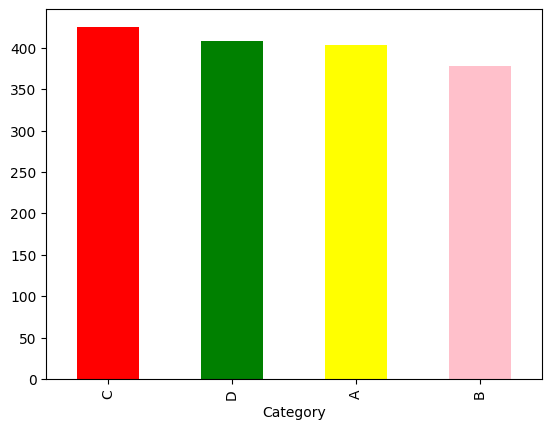

In [127]:
df['Category'].value_counts().plot(kind='bar', color=['red', 'green', 'yellow', 'pink'])

In [128]:
df.shape

(4362, 5)

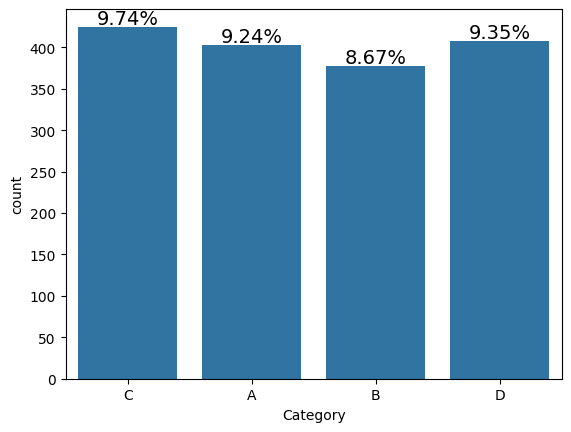

In [129]:
s = sns.countplot(x = 'Category',data = df)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df)*100),
            ha="center", fontsize=14) 

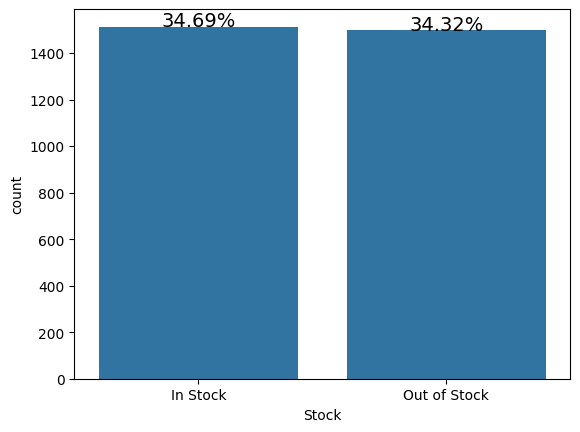

In [130]:
s = sns.countplot(x = 'Stock',data = df)
sizes=[]
for p in s.patches:
    height = p.get_height()
    sizes.append(height)
    s.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.2f}%'.format(height/len(df)*100),
            ha="center", fontsize=14)

In [131]:
df.isnull().sum()

Category    2748
Price        174
Rating      2050
Stock       1352
Discount     392
dtype: int64

In [132]:
missing_percentage = df.isnull().mean() * 100

missing_percentage

Category    62.998624
Price        3.988996
Rating      46.996790
Stock       30.994956
Discount     8.986703
dtype: float64

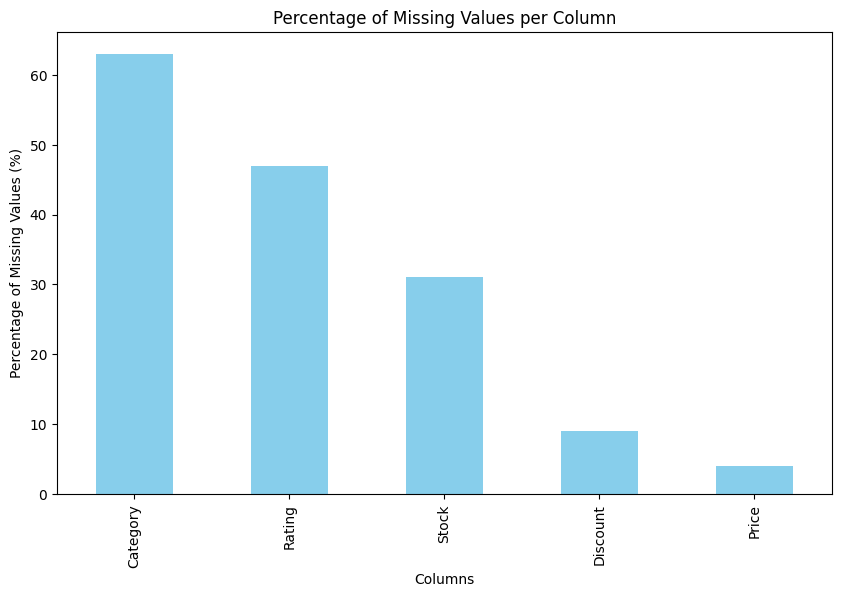

In [133]:
# Plot the bar chart
plt.figure(figsize=(10, 6))
missing_percentage.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Percentage of Missing Values per Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Values (%)')
plt.xticks(rotation=90)
plt.show()

## Detecting missing data visually using Missingno library

>To graphically analyse the missingness of the data, let's use a library called [Missingno](https://github.com/ResidentMario/missingno) It is a package for graphical analysis of missing values. To use this library, we need to import it as follows: `import missingno as msno`

<Axes: >

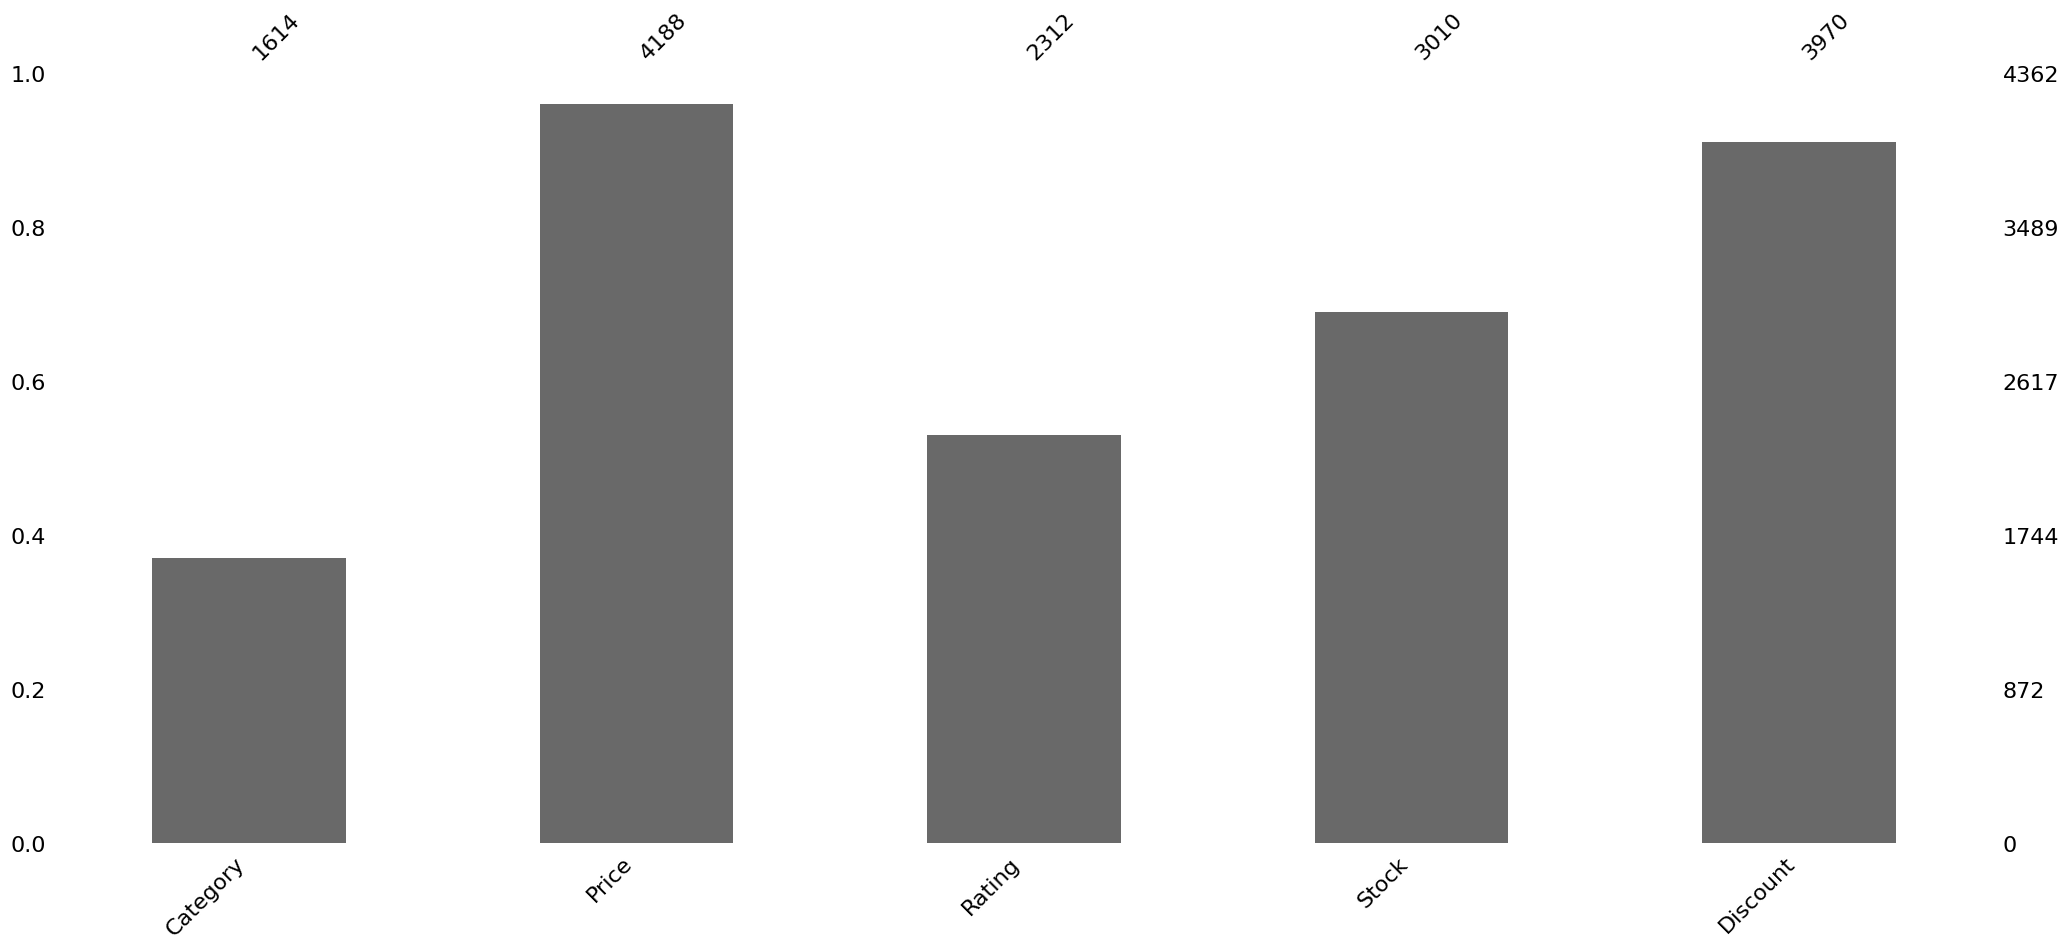

In [134]:
msno.bar(df)

### Visualizing the locations of the missing data 

>The [msno.matrix](https://github.com/ResidentMario/missingno#matrix) nullity matrix is a data-dense display which lets you quickly visually pick out patterns in data completion.


<Axes: >

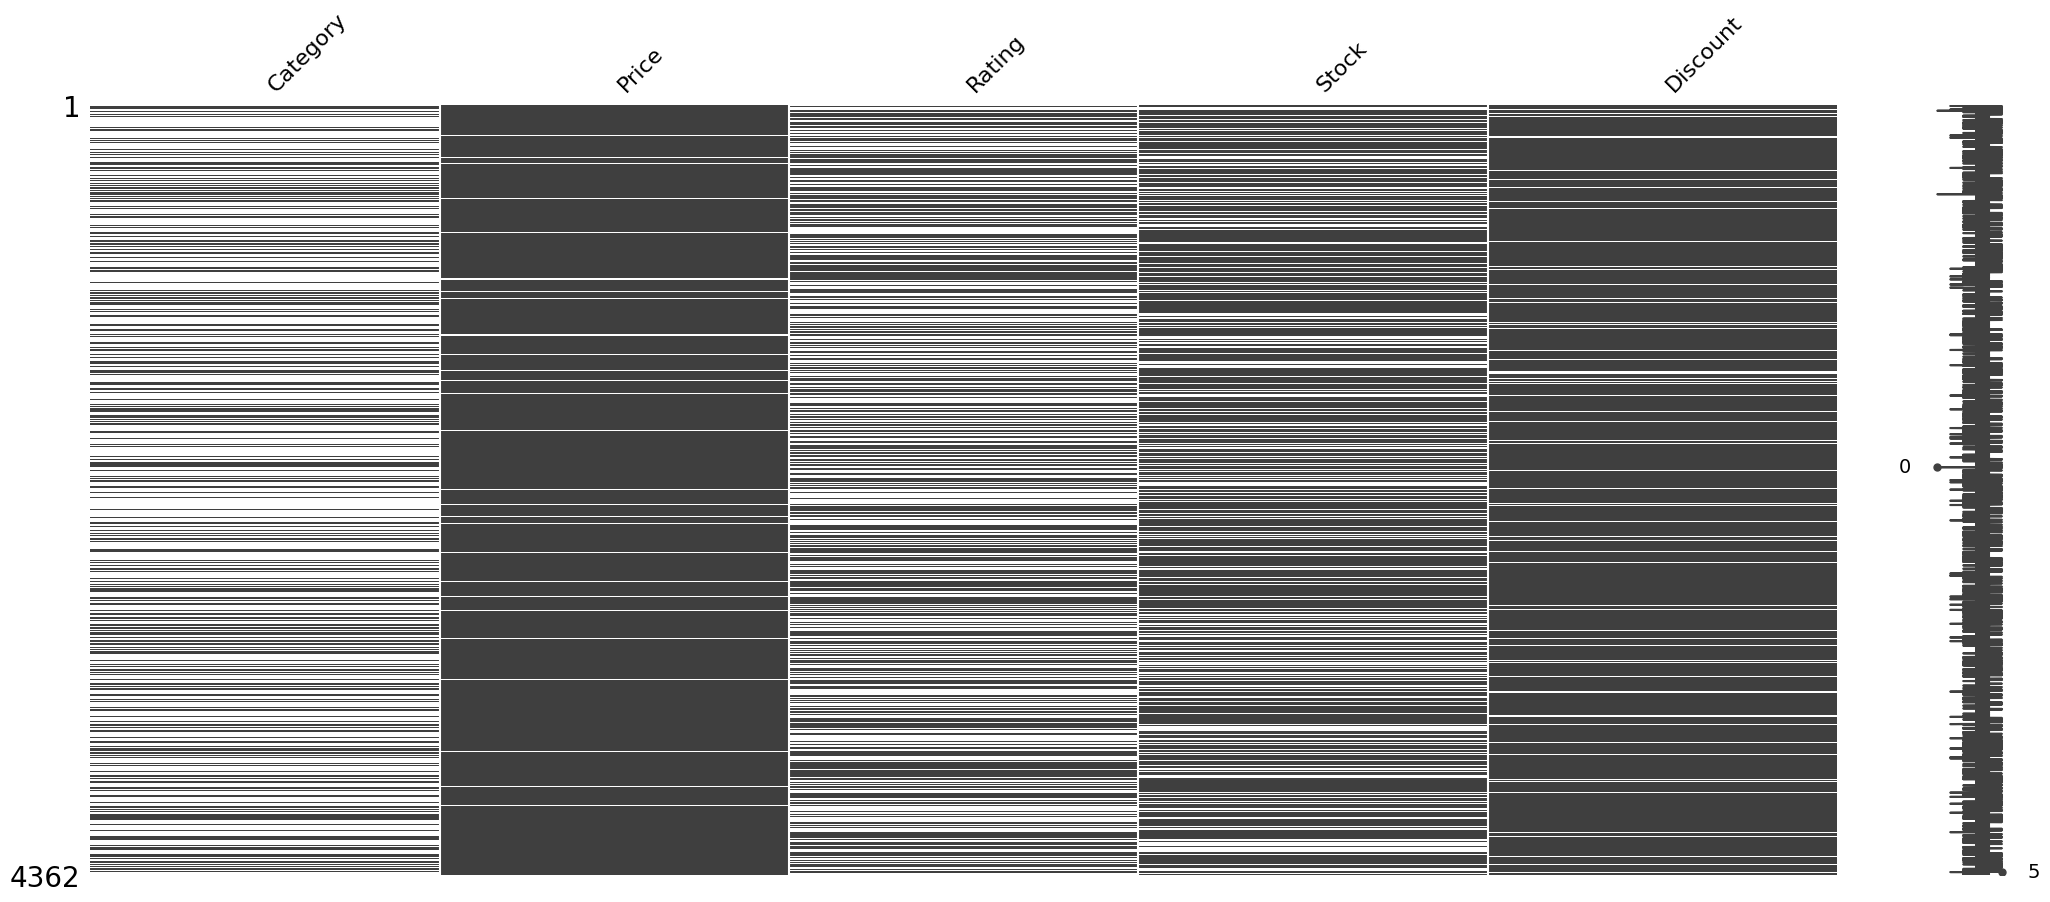

In [135]:
msno.matrix(df)

>* The plot appears blank(white) wherever there are missing values. For instance, in Embarked column there are only two instances of missing data, hence the two white lines.
>
>* The sparkline on the right gives an idea of the general shape of the completeness of the data and points out the row with the minimum nullities and the total number of columns in a given dataset, at the bottom.
>
>It is also possible to sample the dataset to pinpoint the exact location of the missing values. For instance let's check the first 100 rows.

<Axes: >

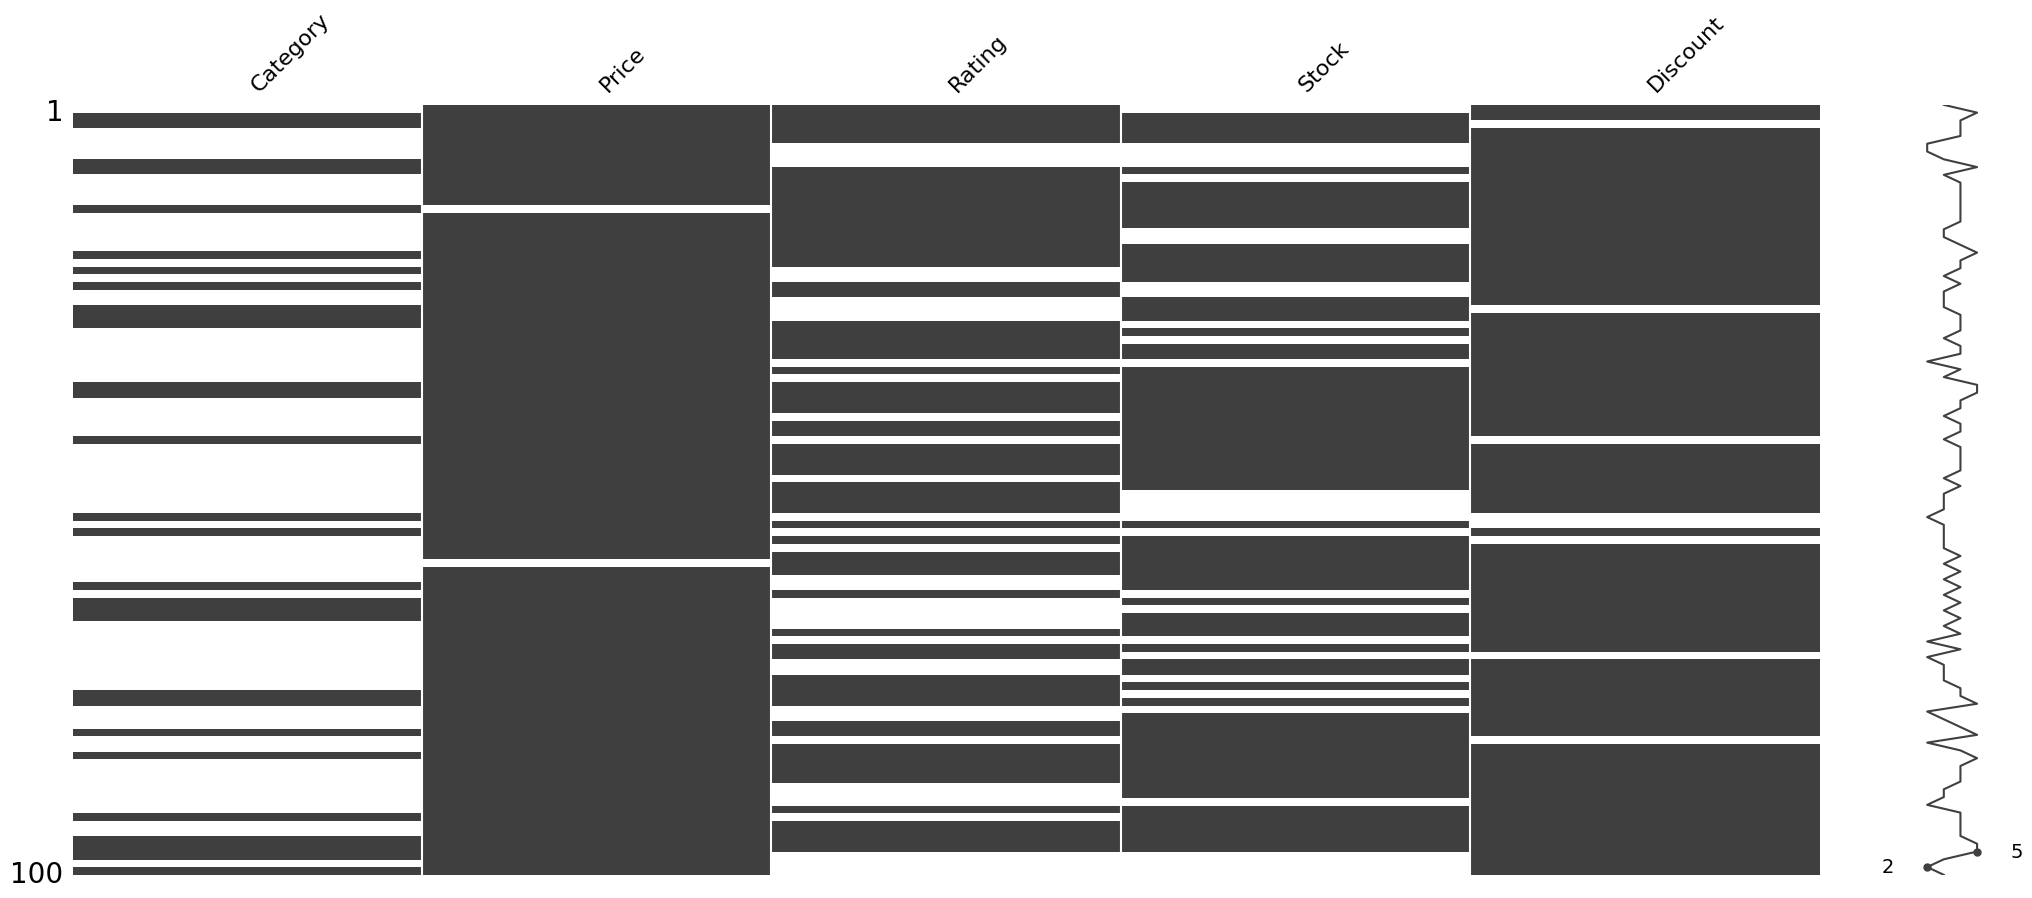

In [136]:
msno.matrix(df.sample(100))

<Axes: >

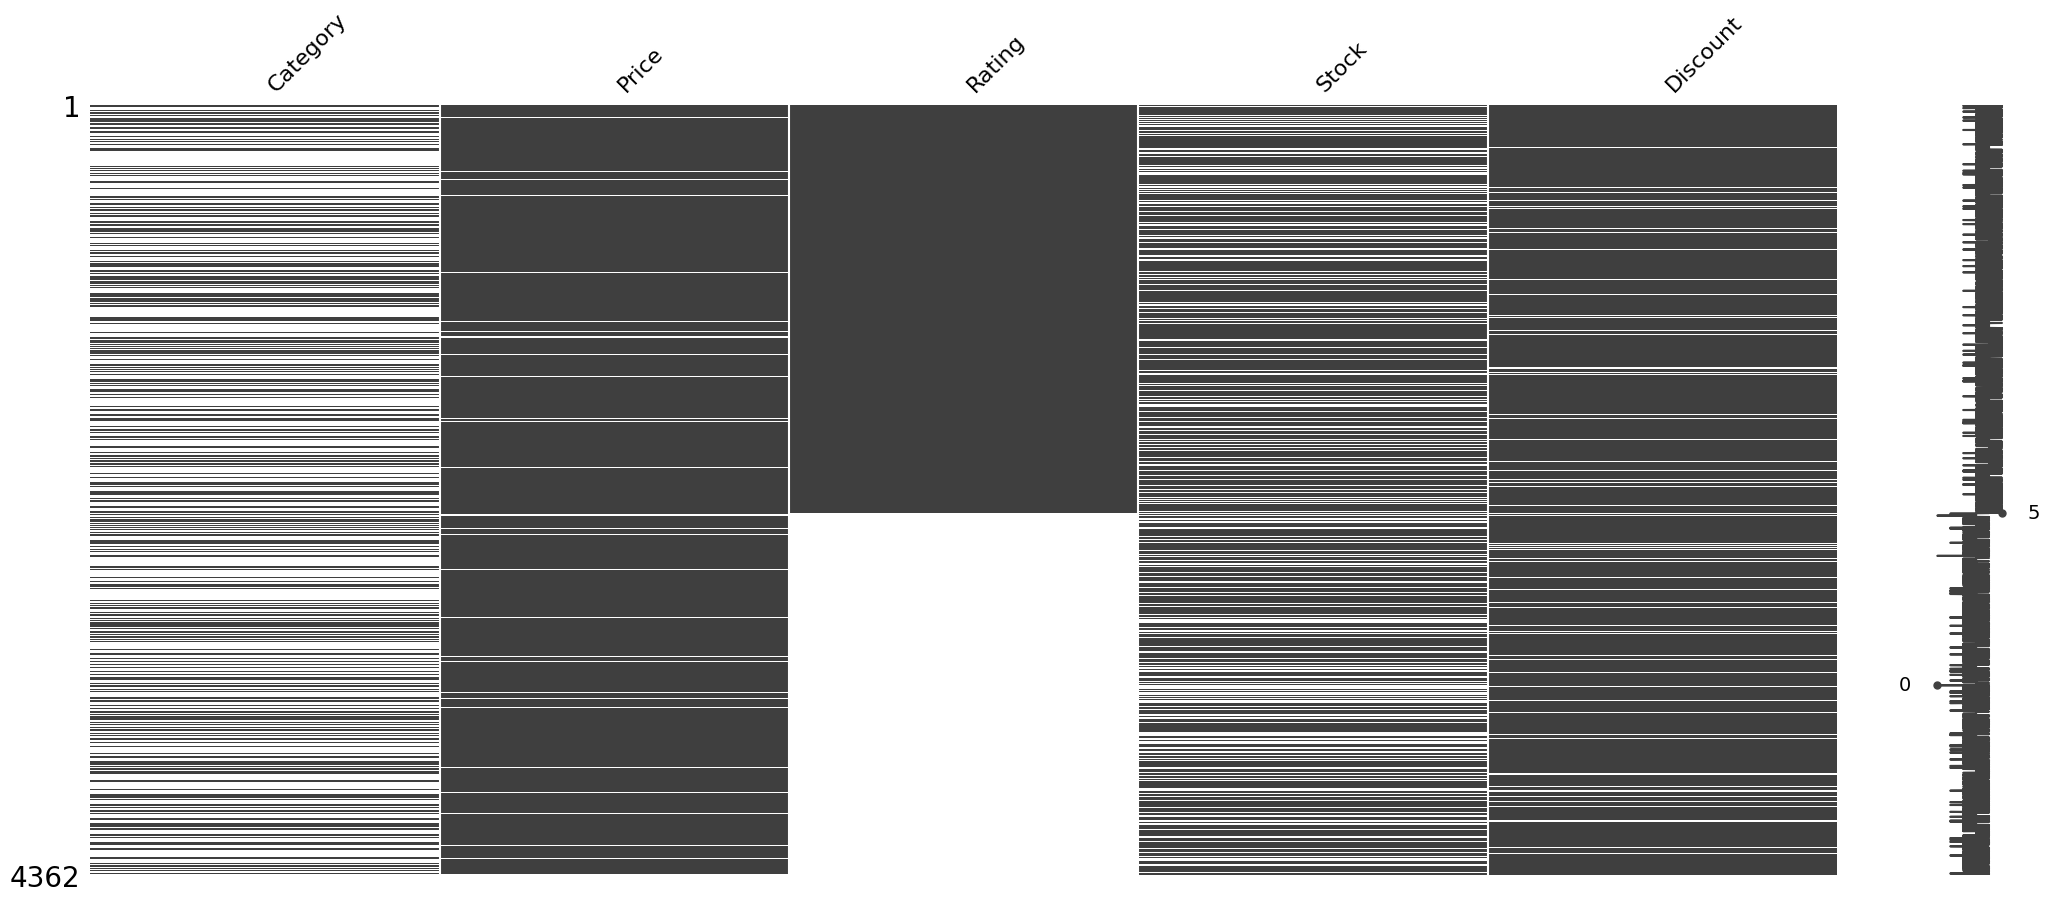

In [137]:
#sorted by Age
sorted = df.sort_values('Rating')
msno.matrix(sorted)

## Finding reason for missing data using a Heatmap 

<Axes: >

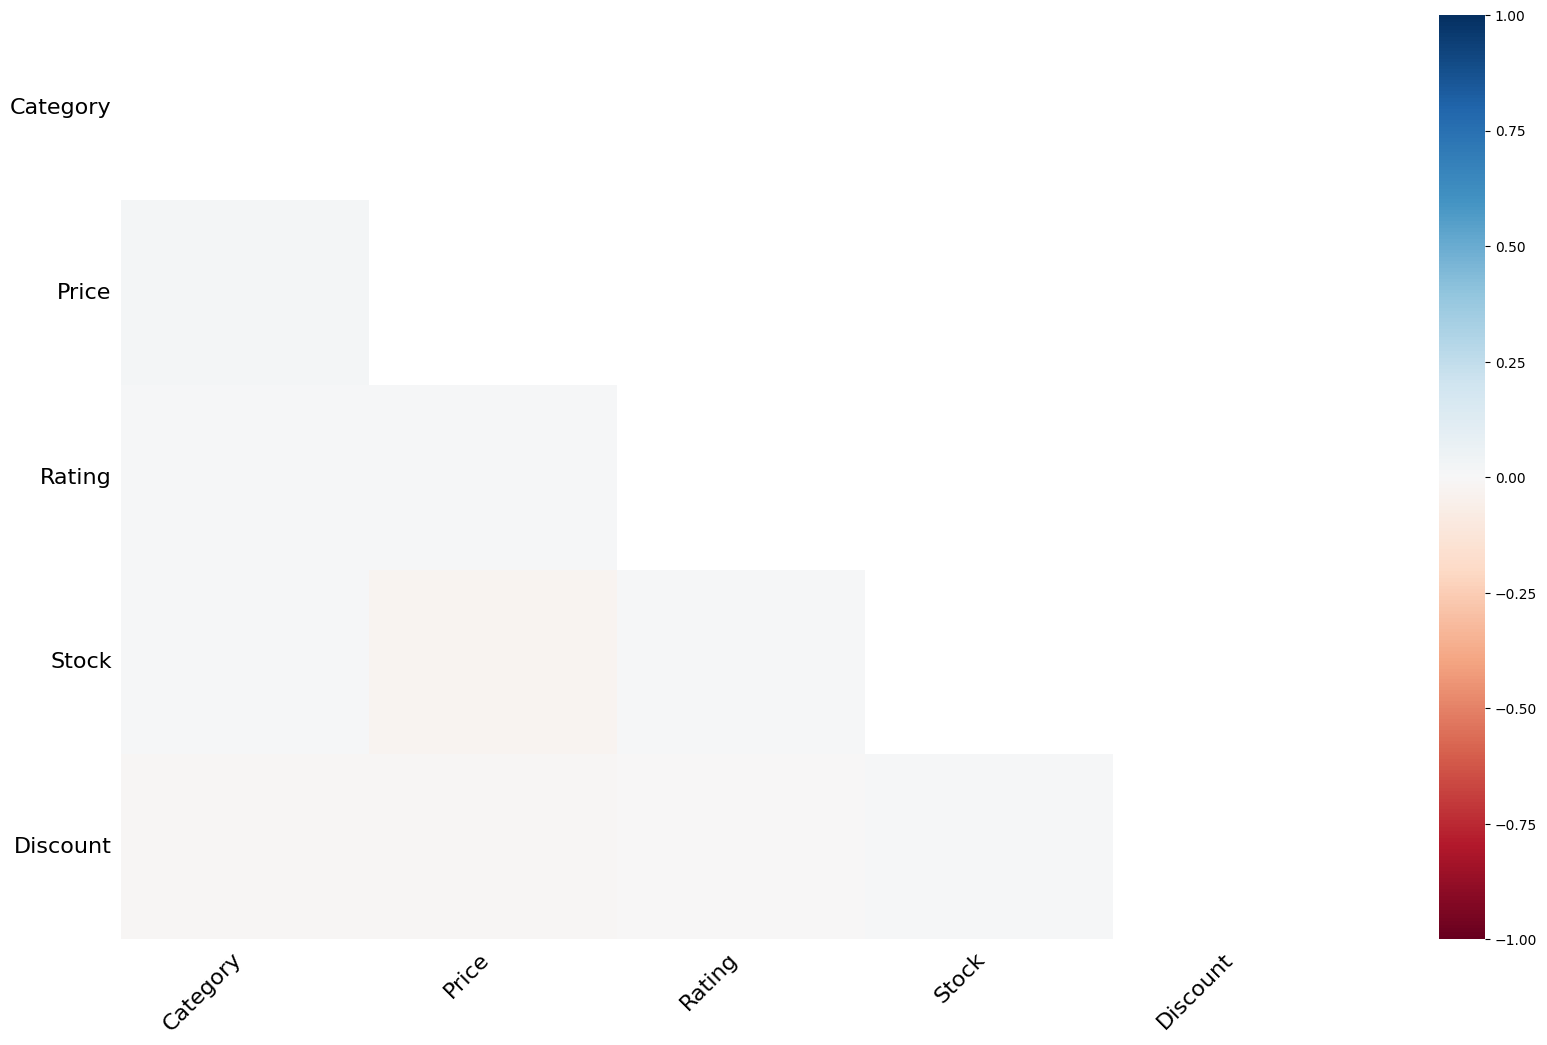

In [138]:
msno.heatmap(df)

The heatmap function shows that there are no strong correlations between missing values of different features. This is good; low correlations further indicate that the data are MAR.

## Finding reason for missing data using Dendrogram 
A dendogram is a tree diagram of missingness. It groups the highly correlated variables together.

<Axes: >

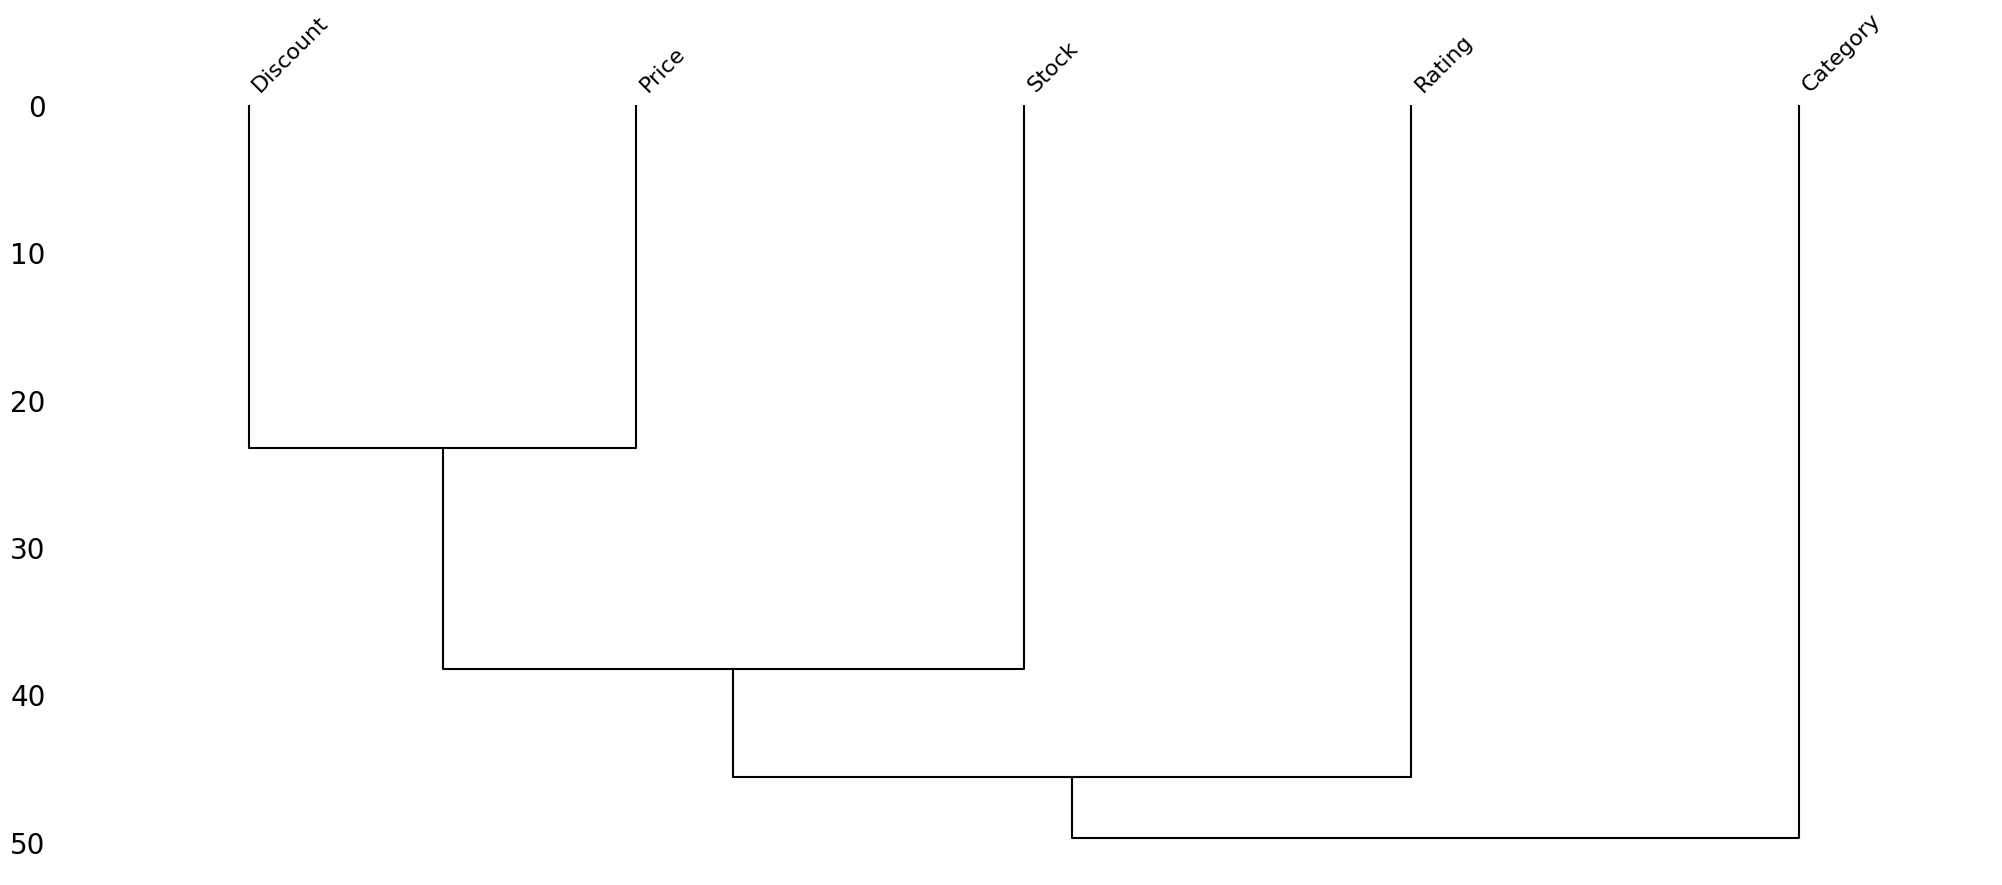

In [139]:
msno.dendrogram(df)

In [140]:
cols = [var for var in df.columns if df[var].isnull().mean() < 0.05 and df[var].isnull().mean() > 0]
cols

['Price']

In [141]:
df[cols].sample(5)

,Price
1391,218.0
500,6551.0
1784,2675.0
2760,1580.0
224,2622.0


In [142]:
len(df[cols].dropna()) / len(df)

0.9601100412654745

In [143]:
df.shape

(4362, 5)

In [144]:
new_df = df[cols].dropna()
df.shape, new_df.shape

((4362, 5), (4188, 1))

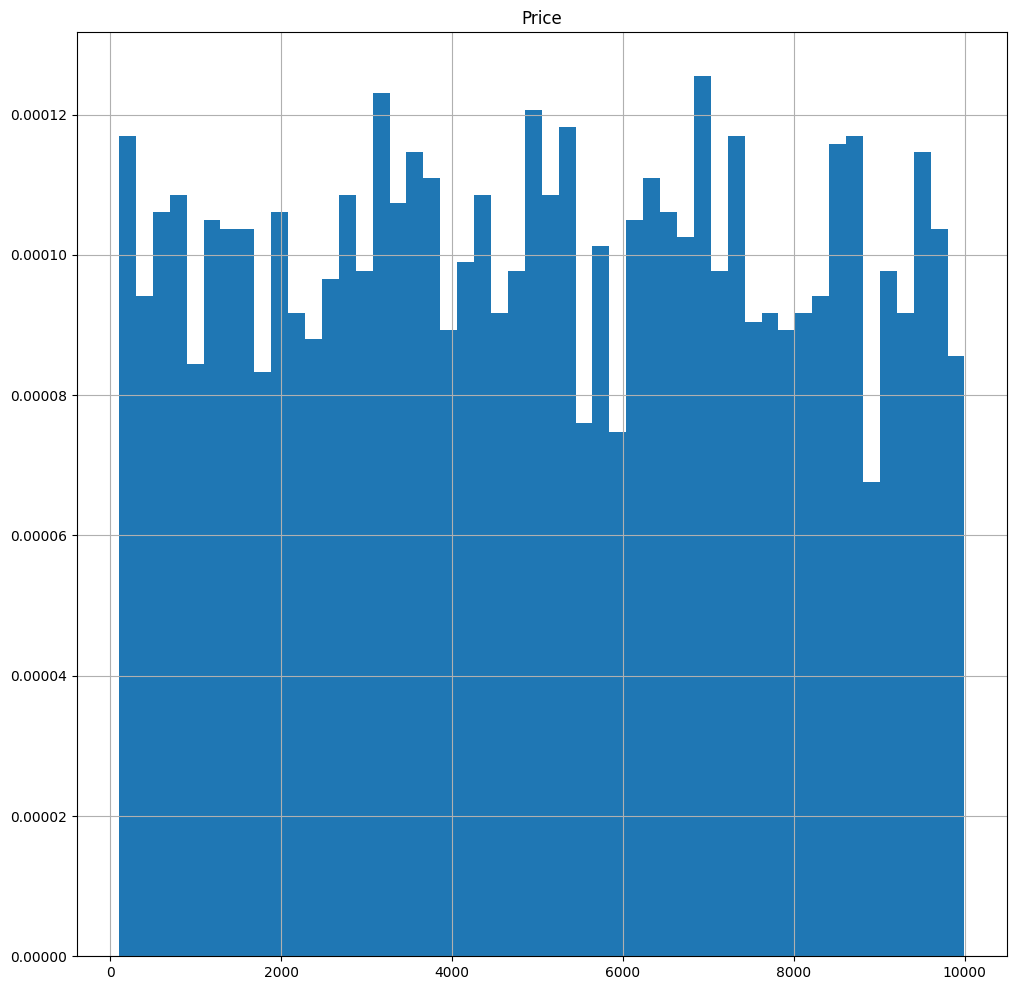

In [83]:
new_df.hist(bins=50, density=True, figsize=(12, 12))
plt.show()

<Axes: ylabel='Density'>

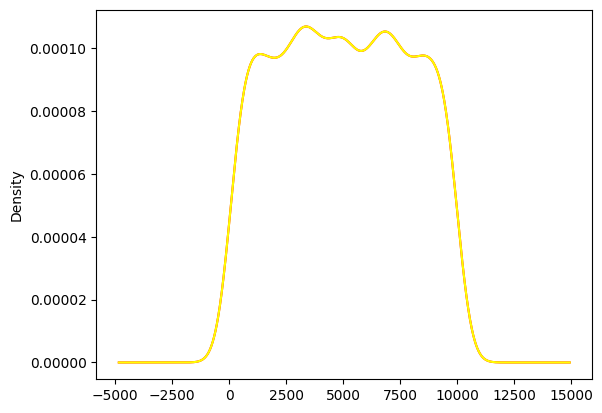

In [145]:
fig = plt.figure()
ax = fig.add_subplot(111)

# original data
df['Price'].plot.density(color='red')

# data after cca
new_df['Price'].plot.density(color='yellow')

In [146]:
temp = pd.concat([
            # percentage of observations per category, original data
            df['Price'].value_counts() / len(df),

            # percentage of observations per category, cca data
            new_df['Price'].value_counts() / len(new_df)
        ],
        axis=1)

# add column names
temp.columns = ['original', 'cca']

temp.head()

,original,cca
Price,,
7446.0,0.000917,0.000955
4887.0,0.000917,0.000955
3282.0,0.000917,0.000955
1493.0,0.000917,0.000955
3182.0,0.000917,0.000955


In [147]:
new_df['Price'].isnull().sum()

0

In [148]:
df = df.drop(columns=['Price'], errors='ignore')

df.head()

,Category,Rating,Stock,Discount
0,NaN,1.870322,NaN,0.0
1,NaN,4.757798,NaN,38.0
2,NaN,NaN,In Stock,0.0
3,NaN,1.492085,NaN,33.0
4,NaN,NaN,Out of Stock,23.0


In [149]:
df1 = pd.concat([df, new_df], axis=1)  

In [150]:
df1.head()

,Category,Rating,Stock,Discount,Price
0,NaN,1.870322,NaN,0.0,5548.0
1,NaN,4.757798,NaN,38.0,3045.0
2,NaN,NaN,In Stock,0.0,4004.0
3,NaN,1.492085,NaN,33.0,4808.0
4,NaN,NaN,Out of Stock,23.0,1817.0


In [151]:
df1['Price'].isnull().sum()

174

In [16]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [17]:
train_1 = train.copy()
train_1['Age'].mean() #pandas skips the missing values and calculates mean of the remaining values.

29.69911764705882


### Listwise Deletion/ Dropping rows

>During Listwise deletion, complete rows(which contain the missing values) are deleted. As a result, it is also called Complete Case deletion. Like Pairwise deletion, listwise deletions are also only used for MCAR values.


In [18]:
#Drop rows which contains any NaN or missing value for Age column
train_1.dropna(subset=['Age'],how='any',inplace=True)
train_1['Age'].isnull().sum()

0

>The Age column doesn't have any missing values.A major diadvantage of Listwise deletion is that a major chunk of data and hence a lot of information is lost. Hence, it is advisable to use it only when the number of missing values is very small.


### Dropping complete columns 

If a column contains a lot of missing values, say more than 80%, and the feature is not significant, you might want to delete that feature. However, again, it is not a good methodology to delete data.


## Imputations Techniques for non Time Series Problems 

![](https://imgur.com/bL0iHde.png)

>Imputation refers to replacing missing data with substituted values.There are a lot of ways in which the missing values can be imputed depending upon the nature of the problem and data. Dependng upon the nature of the problem, imputation techniques can be broadly they can be classified as follows:


### Basic Imputation Techniques
  
  - Imputating with a constant value
  - Imputation using the statistics (mean, median or most frequent) of each column in which the missing values are located

For this we shall use the `The SimpleImputer` class from sklearn.

In [19]:
# imputing with a constant

from sklearn.impute import SimpleImputer
train_constant = train.copy()
#setting strategy to 'constant' 
mean_imputer = SimpleImputer(strategy='constant') # imputing using constant value
train_constant.iloc[:,:] = mean_imputer.fit_transform(train_constant)
train_constant.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [20]:
from sklearn.impute import SimpleImputer
train_most_frequent = train.copy()
#setting strategy to 'mean' to impute by the mean
mean_imputer = SimpleImputer(strategy='most_frequent')# strategy can also be mean or median 
train_most_frequent.iloc[:,:] = mean_imputer.fit_transform(train_most_frequent)

In [21]:
train_most_frequent.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

## Imputations Techniques for Time Series Problems

Now let's look at ways to impute data in a typical time series problem. Tackling missing values in time Series problem is a bit different. The `fillna()` method is used for imputing missing values in such problems.

* Basic Imputation Techniques
  - 'ffill' or 'pad' - Replace NaN s with last observed value
  - 'bfill' or 'backfill' - Replace NaN s with next observed value
  -  Linear interpolation method

### Time Series dataset

The dataset is called [Air Quality Data in India (2015 - 2020)](https://www.kaggle.com/rohanrao/air-quality-data-in-india) Tand it contains air quality data and AQI (Air Quality Index) at hourly and daily level of various stations across multiple cities in India.The dataset has a lot of missing values and and is a classic Time series problem.

In [22]:
os.listdir('../input/air-quality-data-in-india')

['station_hour.csv', 'city_hour.csv', 'station_day.csv', 'city_day.csv']

In [23]:
city_day = pd.read_csv('../input/air-quality-data-in-india/city_day.csv',parse_dates=True,index_col='Date')
city_day1=city_day.copy(deep=True)
city_day.head()

,City,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
Date,,,,,,,,,,,,,,,
2015-01-01,Ahmedabad,NaN,NaN,0.92,18.22,17.15,NaN,0.92,27.64,133.36,0.00,0.02,0.00,NaN,NaN
2015-01-02,Ahmedabad,NaN,NaN,0.97,15.69,16.46,NaN,0.97,24.55,34.06,3.68,5.50,3.77,NaN,NaN
2015-01-03,Ahmedabad,NaN,NaN,17.40,19.30,29.70,NaN,17.40,29.07,30.70,6.80,16.40,2.25,NaN,NaN
2015-01-04,Ahmedabad,NaN,NaN,1.70,18.48,17.97,NaN,1.70,18.59,36.08,4.43,10.14,1.00,NaN,NaN
2015-01-05,Ahmedabad,NaN,NaN,22.10,21.42,37.76,NaN,22.10,39.33,39.31,7.01,18.89,2.78,NaN,NaN


I won't go much into explaining the data since I have done a lot of relatedw work in my kernel titled [😷 Breathe India: COVID-19 effect on Pollution](https://www.kaggle.com/parulpandey/breathe-india-covid-19-effect-on-pollution).In this notebook, let's keep our focus on the missing values only. As id evident, city_day dataframe consists of daily pollution level data of some of the prominent cities in India.



In [24]:
#Missing Values
city_day_missing= missing_values_table(city_day)
city_day_missing

Your selected dataframe has 15 columns.
There are 14 columns that have missing values.


,Missing Values,% of Total Values
Xylene,16989,60.3
PM10,11005,39.1
NH3,10121,35.9
Toluene,7715,27.4
Benzene,5386,19.1
AQI,4575,16.2
AQI_Bucket,4575,16.2
PM2.5,4552,16.2
NOx,4142,14.7
O3,3888,13.8


There are a lot of missing values and some of the columns like Xylene and PM10 have more than 50% of the values missing. Let's now see how we can impute these missing values.



In [25]:
# Imputation using ffill/pad
# Imputing Xylene value

city_day['Xylene'][50:64]


Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26      NaN
2015-02-27      NaN
2015-02-28      NaN
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
Name: Xylene, dtype: float64

Above we see, there are 3 missing values in the Xylene column. 

### Imputing using ffill

In [26]:
city_day.fillna(method='ffill',inplace=True)
city_day['Xylene'][50:65]

Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26     0.81
2015-02-27     0.81
2015-02-28     0.81
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
2015-03-06     4.13
Name: Xylene, dtype: float64

We can see that all missing values have been filled with the last observed values.

### Imputation using bfill

In [27]:
# Imputing AQI value

city_day['AQI'][20:30]

Date
2015-01-21      NaN
2015-01-22      NaN
2015-01-23      NaN
2015-01-24      NaN
2015-01-25      NaN
2015-01-26      NaN
2015-01-27      NaN
2015-01-28      NaN
2015-01-29    209.0
2015-01-30    328.0
Name: AQI, dtype: float64

In [28]:
city_day.fillna(method='bfill',inplace=True)
city_day['AQI'][20:30]

Date
2015-01-21    209.0
2015-01-22    209.0
2015-01-23    209.0
2015-01-24    209.0
2015-01-25    209.0
2015-01-26    209.0
2015-01-27    209.0
2015-01-28    209.0
2015-01-29    209.0
2015-01-30    328.0
Name: AQI, dtype: float64

We can see that all missing values have been filled with the next observed values.

### Imputation using Linear Interpolation method

Time series data has a lot of variations against time. Hence, imputing using backfill and forward fill isn't the ebst possible solution to address the missing value problem. A more apt alternative would be to use interpolation methods, where the values are filled with incrementing or decrementing values.

[Linear interpolation](https://www.lexjansen.com/nesug/nesug01/ps/ps8026.pdf) is an imputation technique that assumes a linear relationship between data points and utilises non-missing values from adjacent data points to compute a value for a missing data point. 

Refer to the official documentation for a complete list of interpolation strategies [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html)

In [29]:
city_day1['Xylene'][50:65]

Date
2015-02-20     7.48
2015-02-21    15.44
2015-02-22     8.47
2015-02-23    28.46
2015-02-24     6.05
2015-02-25     0.81
2015-02-26      NaN
2015-02-27      NaN
2015-02-28      NaN
2015-03-01     1.32
2015-03-02     0.22
2015-03-03     2.25
2015-03-04     1.55
2015-03-05     4.13
2015-03-06      NaN
Name: Xylene, dtype: float64

In [30]:
# Interpolate using the linear method
city_day1.interpolate(limit_direction="both",inplace=True)
city_day1['Xylene'][50:65]

Date
2015-02-20     7.4800
2015-02-21    15.4400
2015-02-22     8.4700
2015-02-23    28.4600
2015-02-24     6.0500
2015-02-25     0.8100
2015-02-26     0.9375
2015-02-27     1.0650
2015-02-28     1.1925
2015-03-01     1.3200
2015-03-02     0.2200
2015-03-03     2.2500
2015-03-04     1.5500
2015-03-05     4.1300
2015-03-06     2.2600
Name: Xylene, dtype: float64

## Advanced Imputation Techniques 

Advanced imputation techniques uses machine learning algorithms to impute the missing values in a dataset unlike the previous techniques where we used other column values to predict the missing values. We shall look at the following two techniques in this notebook:

* [Nearest neighbors imputation](https://scikit-learn.org/stable/modules/impute.html#nearest-neighbors-imputation)
* [Multivariate feature imputation](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation)

### K-Nearest Neighbor Imputation

The [KNNImputer class](https://scikit-learn.org/stable/modules/impute.html#multivariate-feature-imputation) provides imputation for filling in missing values using the k-Nearest Neighbors approach.Each missing feature is imputed using values from n_neighbors nearest neighbors that have a value for the feature. The feature of the neighbors are averaged uniformly or weighted by distance to each neighbor. 

In [31]:
train_knn = train.copy(deep=True)

In [32]:
from sklearn.impute import KNNImputer
train_knn = train.copy(deep=True)

knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
train_knn['Age'] = knn_imputer.fit_transform(train_knn[['Age']])

In [33]:
train_knn['Age'].isnull().sum()


0

### Multivariate feature imputation - Multivariate imputation by chained equations (MICE)
A strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion. It performns multiple regressions over random sample ofthe data, then takes the average ofthe multiple regression values and uses that value to impute the missing value. In sklearn, it is implemented as follows:



In [34]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
train_mice = train.copy(deep=True)

mice_imputer = IterativeImputer()
train_mice['Age'] = mice_imputer.fit_transform(train_mice[['Age']])

In [35]:
train_mice['Age'].isnull().sum()

0

# Algorithms which handle missing values

Some algprithms like XGBoost and LightGBM can handle missing values without any preprocessing, by supplying relevant parameters.

* [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
![](https://imgur.com/GNlcWoJ.png)

* [LightGBm](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html)
![](https://imgur.com/GVdcx7h.png)


# Conclusion

Well, there is no single best way to handle missing values. One needs to experiment with different methods and then decide which method is best for a particular problem.

# References and good resources 

* [Dealing with Missing Data in Python](https://campus.datacamp.com/courses/dealing-with-missing-data-in-python/the-problem-with-missing-data?ex=1)
* [How to Handle Missing Data](https://towardsdatascience.com/how-to-handle-missing-data-8646b18db0d4)